In [29]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import sys, os
from os.path import join, dirname
main_dir = dirname(os.getcwd())
sys.path.append(main_dir)

In [31]:
import numpy as np
from time import time
import matplotlib.pyplot as plt # type: ignore
import casadi as ca # type: ignore
import si4kalman
rng = np.random.default_rng(seed=0)

In [32]:
def diff(x1, x2):
    return np.sum((x1-x2)**2)

# Problem definition

In [33]:
umax = 50
dt = 1.

In [34]:
Ntrain = 3000

model_true = si4kalman.minimal_model(dt, umax, Text=0.)
model = si4kalman.minimal_model(dt, umax, Text=0.)

x0 = np.zeros(model_true.nx)
P0 = np.eye(model_true.nx) * 0.


# Data generation 

In [35]:
us_train = model_true.generate_u(rng, Ntrain, umax=umax, step = 10)

In [36]:
# noise in the true data
alpha_true, beta_true = model_true.draw(rng) # choose a "true parameter randomly"

<IPython.core.display.Javascript object>


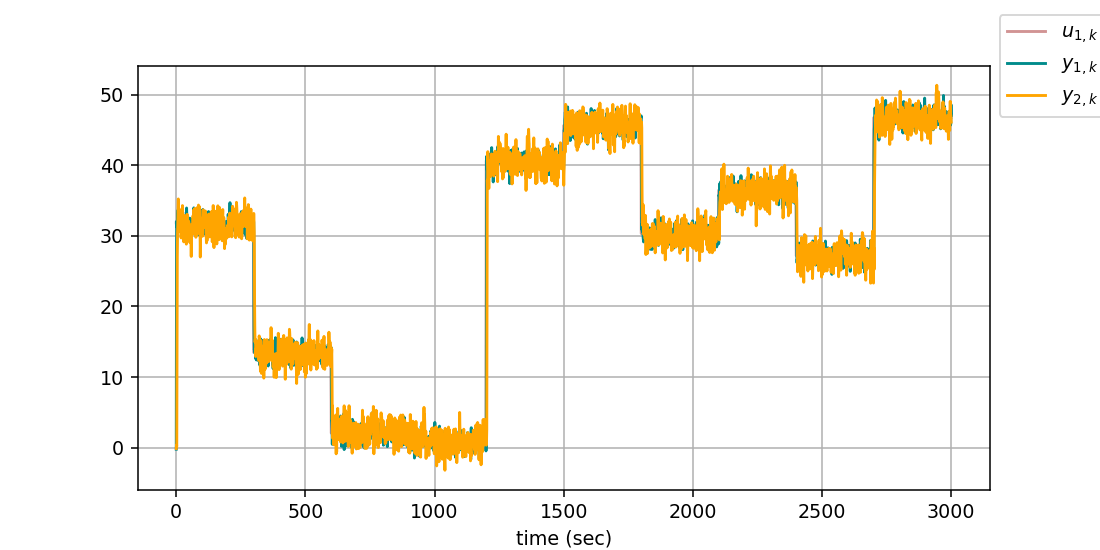

In [37]:
ys_train, _ = model_true.simulation(x0, us_train, alpha_true,  beta_true, rng)

assert model_true.feasible(alpha_true, beta_true), "Constraints should be satisfied for the true parameters"

# Estimation

In [38]:
alpha_true, beta_true

(array([0.81585355, 0.0027385 ]), array([0.85740428, 0.03358558]))

In [48]:
# the flag lti allow to speed things up for LTI systems 
problemTrain = si4kalman.ProblemParser(
    model, ys_train, us_train, x0, P0, lti=True)

In [49]:
opts = {"pen_step":1e-4, "maxiter":20, "tol.direction":0., "tol.kkt":1e-8}

In [50]:
Ns = [200, 500, 1000, 1500]

In [51]:
## Optimize over the Kalman filter
res = {}

alpha0 = np.ones(model.nalpha) * 0.5
beta0 = np.ones(model.nbeta) * 0.5
for formulation in ["ExactIPOPT", "ExactSQP"]:
    infos = {}
    for N in Ns:
        print("Formulation : {}, N = {}".format(formulation, N))
        problemTrain.cut(N)
        t0 = time()
        alpha, beta, stats = problemTrain.solve(alpha0, beta0, formulation, opts, verbose=False, rescale=False)
        rtime = time() - t0
        error_alpha = diff(alpha, alpha_true)
        error_beta = diff(beta, beta_true)
        error = error_alpha + error_beta
        if formulation[-3:] == "SQP":
            niter = stats['niter']
        else:
            niter = 1
        info = {
                "rtime": rtime,
                "status":stats["return_status"],
                "rtime-per-iter": rtime/niter,
                "alpha": alpha.copy(),
                "beta": beta.copy(),
                "alpha_true": alpha_true.copy(),
                "beta_true": beta_true.copy(),
                "error": error,
                "error_alpha":error_alpha,
                "error_beta":error_beta
            }
        infos[N] = info
        print("rtime : {:.2e}  status : {}".format(rtime, stats["return_status"]))
        
        alpha0 = alpha.copy() # for making faster, to remove
        beta0 = beta.copy()
        
    res[formulation] = infos

Formulation : ExactIPOPT, N = 200
rtime : 1.31e+00  status : Solve_Succeeded
Formulation : ExactIPOPT, N = 500
rtime : 2.68e+00  status : Solve_Succeeded
Formulation : ExactIPOPT, N = 1000
rtime : 6.51e+00  status : Solve_Succeeded
Formulation : ExactIPOPT, N = 1500
rtime : 1.10e+01  status : Solve_Succeeded
Formulation : ExactSQP, N = 200
rtime : 5.36e-01  status : rtol.cost_decrease
Formulation : ExactSQP, N = 500
rtime : 9.11e-01  status : rtol.cost_decrease
Formulation : ExactSQP, N = 1000
rtime : 1.20e+00  status : rtol.cost_decrease
Formulation : ExactSQP, N = 1500
rtime : 2.85e+00  status : rtol.cost_decrease


In [52]:
for formulation, infos in res.items():
    print("solution for", formulation)
    for N, info in infos.items():
        print("N = {}".format(N))
        print("Running time : {:.2e}".format(info["rtime"]))
        print("Error : {:.2e}".format(info["error"]))
        print("Status : {}".format(info["status"]))
        print("beta_true : {}".format(info["beta_true"]))
        print("beta : {}".format(info["beta"]))
        print("alpha_true : {}".format(info["alpha_true"]))
        print("alpha : {}".format(info["alpha"]))

        print(" ")
    print(" ")

solution for ExactIPOPT
N = 200
Running time : 1.31e+00
Error : 1.02e-03
Status : Solve_Succeeded
beta_true : [0.85740428 0.03358558]
beta : [0.83330286 0.05077359]
alpha_true : [0.81585355 0.0027385 ]
alpha : [0.80517666 0.00777082]
 
N = 500
Running time : 2.68e+00
Error : 7.37e-04
Status : Solve_Succeeded
beta_true : [0.85740428 0.03358558]
beta : [0.84957011 0.05472816]
alpha_true : [0.81585355 0.0027385 ]
alpha : [0.80083118 0.00453839]
 
N = 1000
Running time : 6.51e+00
Error : 7.13e-05
Status : Solve_Succeeded
beta_true : [0.85740428 0.03358558]
beta : [0.86169448 0.03217635]
alpha_true : [0.81585355 0.0027385 ]
alpha : [0.80885399 0.0041308 ]
 
N = 1500
Running time : 1.10e+01
Error : 2.07e-04
Status : Solve_Succeeded
beta_true : [0.85740428 0.03358558]
beta : [0.87158839 0.03354947]
alpha_true : [0.81585355 0.0027385 ]
alpha : [0.81833543 0.00307657]
 
 
solution for ExactSQP
N = 200
Running time : 5.36e-01
Error : 8.78e-04
Status : rtol.cost_decrease
beta_true : [0.85740428 0

<IPython.core.display.Javascript object>


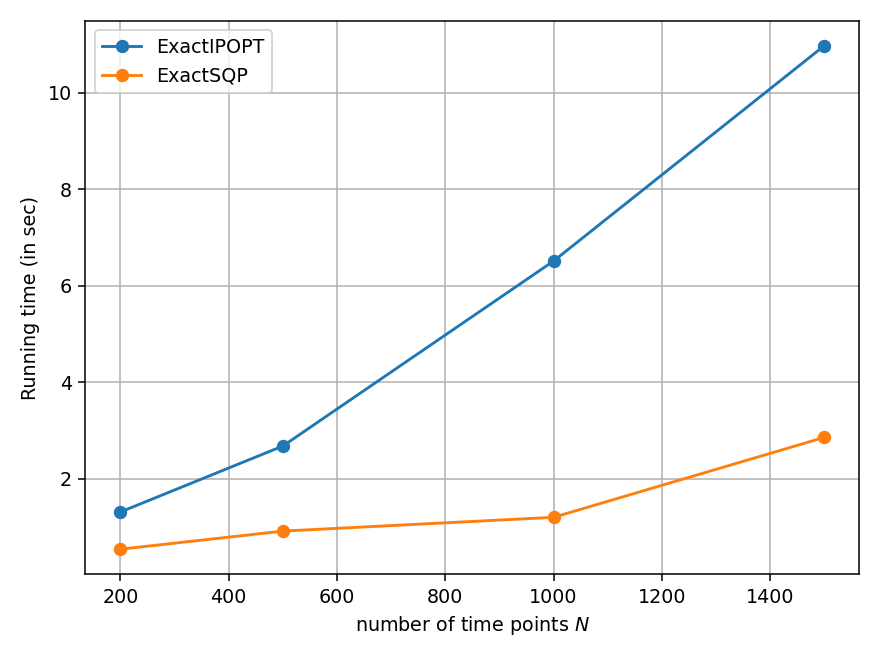

In [53]:
fig = si4kalman.plot_res(res, "rtime", scale="lin")

<IPython.core.display.Javascript object>


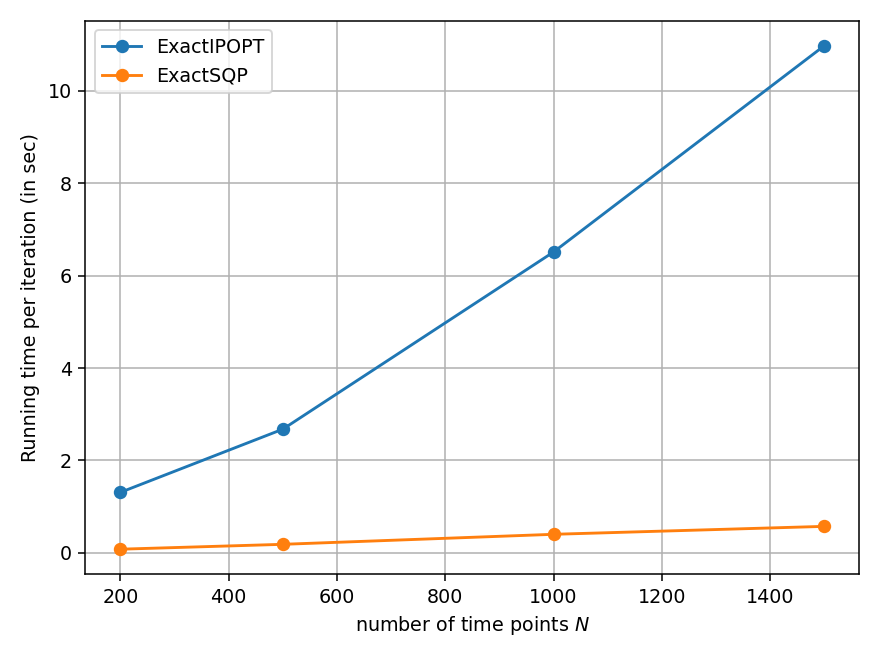

In [54]:
fig = si4kalman.plot_res(res, "rtime-per-iter", scale="lin")

<IPython.core.display.Javascript object>


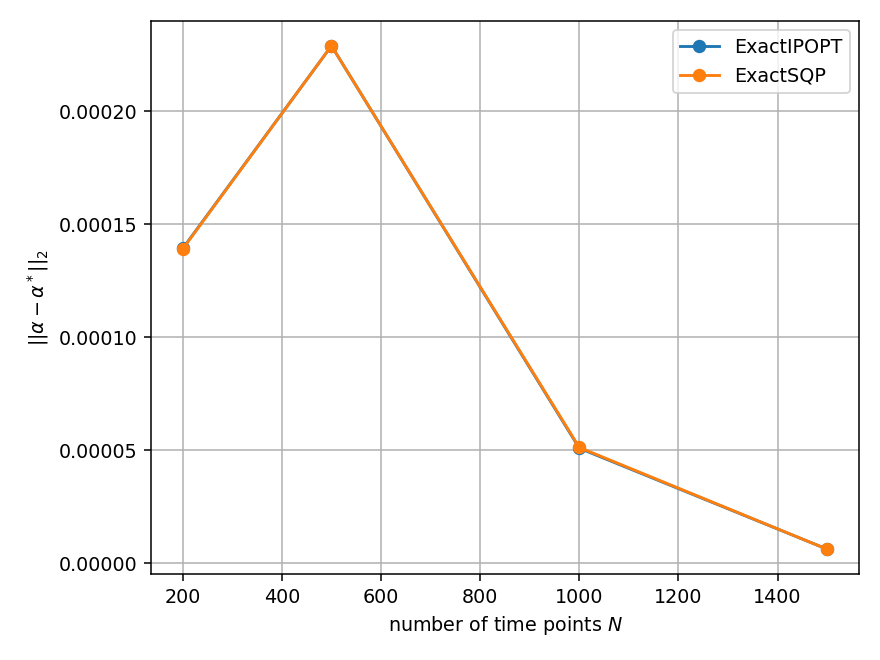

In [55]:
fig = si4kalman.plot_res(res, "error_alpha")

<IPython.core.display.Javascript object>


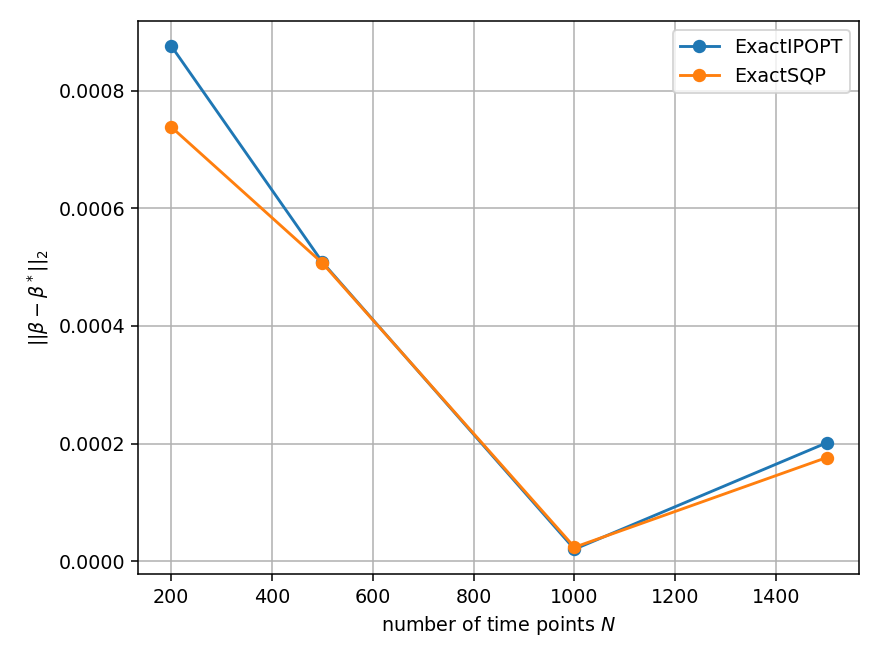

In [56]:
fig = si4kalman.plot_res(res, "error_beta")